In [2]:
def find_empty(board):
  for i in range(len(board)):
      for j in range(len(board[0])):
        if board[i][j] == 0:
          return (i, j) # row, col

  return None

def valid(board, num, pos):
# Check row
  for i in range(len(board[0])):
    if board[pos[0]][i] == num and pos[1] != i:
      return False

# Check column
  for i in range(len(board)):
    if board[i][pos[1]] == num and pos[0] != i:
      return False

# Check box
  box_x = pos[1] // 3
  box_y = pos[0] // 3

  for i in range(box_y*3, box_y*3 + 3):
    for j in range(box_x * 3, box_x*3 + 3):
      if board[i][j] == num and (i,j) != pos:
        return False

  return True

def solve(board):
  find = find_empty(board)
  if not find:
    return True
  else:
    row, col = find

  for i in range(1,10):
    if valid(board, i, (row, col)):
      board[row][col] = i

  if solve(board):
    return True
  board[row][col] = 0
  return False

def get_board(bo):
  if solve(bo):
    return bo
  else:
    raise ValueError

In [3]:
import cv2
import numpy as np
import tensorflow
from tensorflow.keras.models import load_model
import imutils
from google.colab.patches import cv2_imshow
#from solver import *

In [4]:
!pip install -U keras

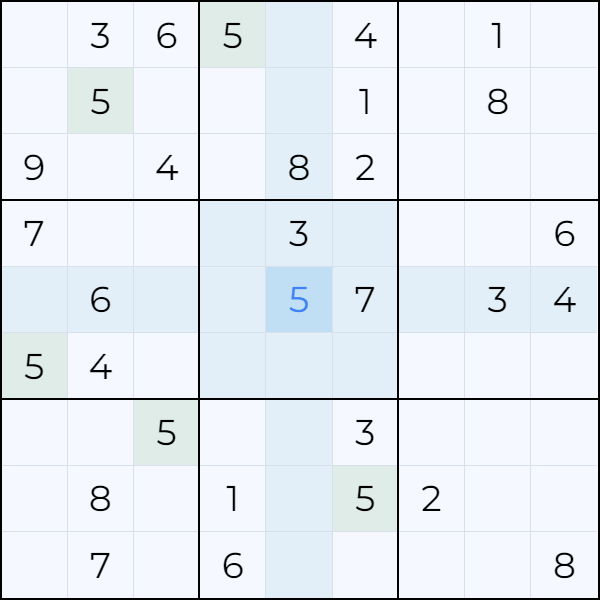

In [5]:
img = cv2.imread('/content/sudoku1.png')
cv2_imshow(img)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
def find_board(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  bfilter = cv2.bilateralFilter(gray, 13, 20, 20)
  edged = cv2.Canny(bfilter, 30, 180)
  keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE,
  cv2.CHAIN_APPROX_SIMPLE)
  contours = imutils.grab_contours(keypoints)
  newimg = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3)
  cv2_imshow(newimg)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
  location = None

  for contour in contours:
    approx = cv2.approxPolyDP(contour, 15, True)
    if len(approx) == 4:
      location = approx
      break
  result = get_perspective(img, location)
  return result, location

In [8]:
def get_perspective(img, location, height = 900, width = 900):
  """Takes an image and location of an interesting region.
  And return the only selected region with a perspective transformation"""
  pts1 = np.float32([location[0], location[3], location[1], location[2]])
  pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

  # Apply Perspective Transform Algorithm
  matrix = cv2.getPerspectiveTransform(pts1, pts2)
  result = cv2.warpPerspective(img, matrix, (width, height))
  return result

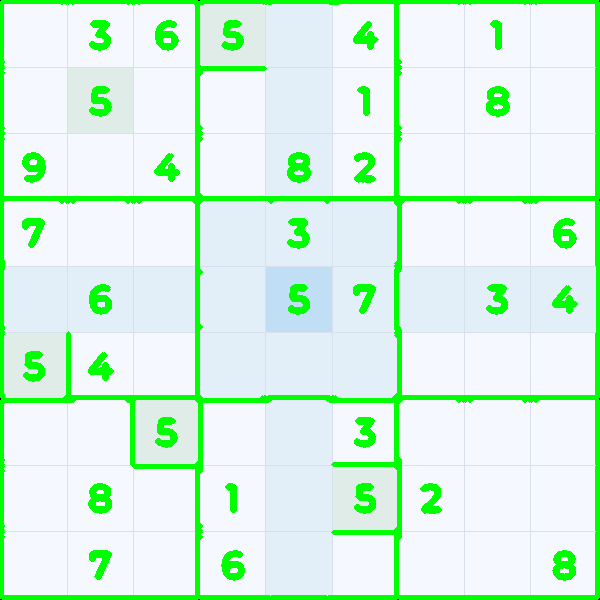

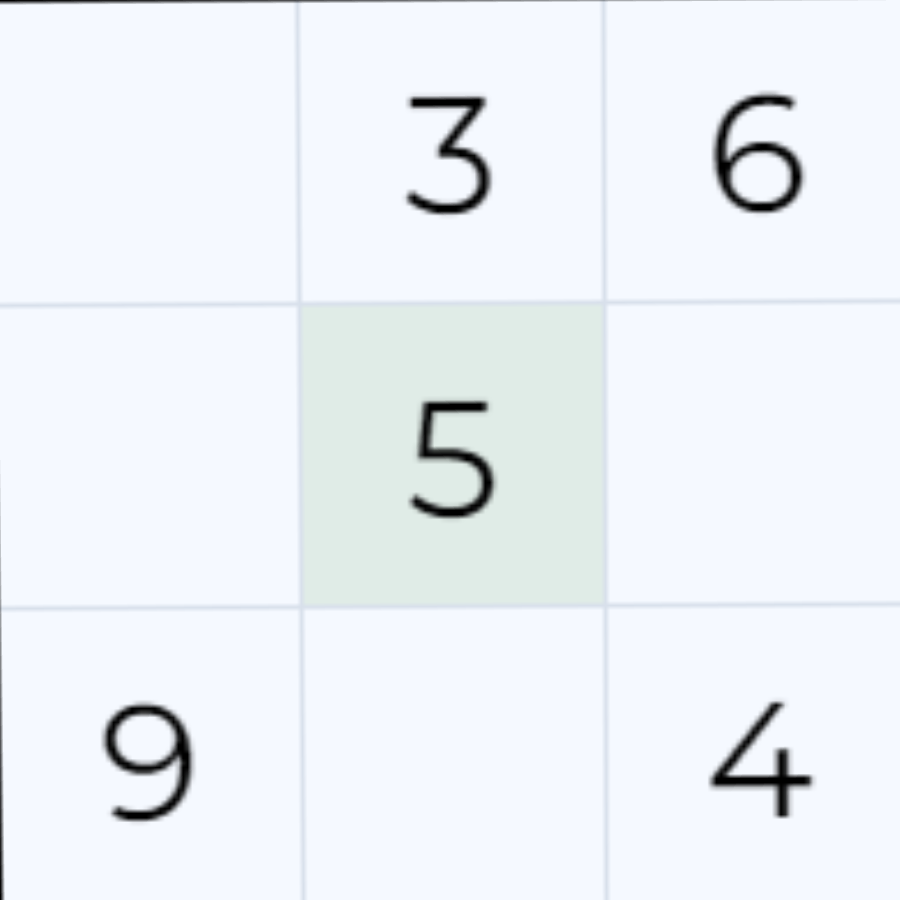

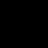

In [9]:
board, location = find_board(img)
cv2_imshow(board)
input_size = 48
# split the board into 81 individual images
def split_boxes(board):
  """Takes a sudoku board and split it into 81 cells.
  each cell contains an element of that board either given or an empty cell."""
  rows = np.vsplit(board,9)
  boxes = []
  for r in rows:
    cols = np.hsplit(r,9)
  for box in cols:
    box = cv2.resize(box, (input_size, input_size))/255.0
  cv2_imshow(box)
  cv2.waitKey(50)
  boxes.append(box)
  return boxes
gray = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)
rois = split_boxes(gray)
rois = np.array(rois).reshape(-1, input_size, input_size, 1)

In [10]:
def get_InvPerspective(img, masked_num, location, height = 900, width = 900):
  """Takes original image as input"""
  pts1 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
  pts2 = np.float32([location[0], location[3], location[1], location[2]])

  # Apply Perspective Transform Algorithm
  matrix = cv2.getPerspectiveTransform(pts1, pts2)
  result = cv2.warpPerspective(masked_num, matrix, (img.shape[1],
  img.shape[0]))
  return result

In [11]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import imutils
#from solver import *

classes = np.arange(0, 10)

model = load_model('model-OCR.h5')
# print(model.summary())
input_size = 48


def get_perspective(img, location, height = 900, width = 900):
    """Takes an image and location os interested region.
        And return the only the selected region with a perspective transformation"""
    pts1 = np.float32([location[0], location[3], location[1], location[2]])
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img, matrix, (width, height))
    return result

def get_InvPerspective(img, masked_num, location, height = 900, width = 900):
    """Takes original image as input"""
    pts1 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    pts2 = np.float32([location[0], location[3], location[1], location[2]])

    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(masked_num, matrix, (img.shape[1], img.shape[0]))
    return result

def find_empty(board):
    """checkes where is an empty or unsolved block"""
    for i in range(len(board)):
        for j in range(len(board[0])):
            if board[i][j] == 0:
                return (i, j)  # row, col

    return None

def valid(board, num, pos):
    # Check row
    for i in range(len(board[0])):
        if board[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(board)):
        if board[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if board[i][j] == num and (i,j) != pos:
                return False

    return True


def solve(board):
    find = find_empty(board)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(board, i, (row, col)):
            board[row][col] = i

            if solve(board):
                return True
            board[row][col] = 0
    return False


def get_board(bo):
    """Takes a 9x9 matrix unsolved sudoku board and returns a fully solved board."""
    if solve(bo):
        return bo
    else:
        raise ValueError






def find_board(img):
    """Takes an image as input and finds a sudoku board inside of the image"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray, 13, 20, 20)
    edged = cv2.Canny(bfilter, 30, 180)
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours  = imutils.grab_contours(keypoints)

    newimg = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3)
    # cv2.imshow("Contour", newimg)


    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
    location = None

    # Finds rectangular contour
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 15, True)
        if len(approx) == 4:
            location = approx
            break
    result = get_perspective(img, location)
    return result, location


# split the board into 81 individual images
def split_boxes(board):
    """Takes a sudoku board and split it into 81 cells.
        each cell contains an element of that board either given or an empty cell."""
    rows = np.vsplit(board,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            box = cv2.resize(box, (input_size, input_size))/255.0
            # cv2.imshow("Splitted block", box)
            # cv2.waitKey(50)
            boxes.append(box)
    cv2.destroyAllWindows()
    return boxes

def displayNumbers(img, numbers, color=(0, 255, 0)):
    """Displays 81 numbers in an image or mask at the same position of each cell of the board"""
    W = int(img.shape[1]/9)
    H = int(img.shape[0]/9)
    for i in range (9):
        for j in range (9):
            if numbers[(j*9)+i] !=0:
                cv2.putText(img, str(numbers[(j*9)+i]), (i*W+int(W/2)-int((W/4)), int((j+0.7)*H)), cv2.FONT_HERSHEY_COMPLEX, 2, color, 2, cv2.LINE_AA)
    return img

# Read image
img = cv2.imread('/content/sudoku1.png')


# extract board from input image
board, location = find_board(img)


gray = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)
# print(gray.shape)
rois = split_boxes(gray)
rois = np.array(rois).reshape(-1, input_size, input_size, 1)

# get prediction
prediction = model.predict(rois)
#print(prediction)

predicted_numbers = []
# get classes from prediction
for i in prediction:
    index = (np.argmax(i)) # returns the index of the maximum number of the array
    predicted_number = classes[index]
    predicted_numbers.append(predicted_number)

print(predicted_numbers)

# reshape the list
board_num = np.array(predicted_numbers).astype('uint8').reshape(9, 9)
print(board_num)
# solve the board
try:
    #print(get_board(board_num))
    solved_board_nums = get_board(board_num)
    print(solved_board_nums)
    # create a binary array of the predicted numbers. 0 means unsolved numbers of sudoku and 1 means given number.
    binArr = np.where(np.array(predicted_numbers)>0, 0, 1)
    # print(binArr)
    # get only solved numbers for the solved board
    flat_solved_board_nums = solved_board_nums.flatten()*binArr
    # create a mask
    mask = np.zeros_like(board)
    # displays solved numbers in the mask in the same position where board numbers are empty
    solved_board_mask = displayNumbers(mask, flat_solved_board_nums)
    # cv2.imshow("Solved Mask", solved_board_mask)
    inv = get_InvPerspective(img, solved_board_mask, location)
    # cv2.imshow("Inverse Perspective", inv)
    combined = cv2.addWeighted(img, 0.7, inv, 1, 0)
    cv2_imshow("Final result", combined)
    # cv2.waitKey(0)


except:
    print("Solution doesn't exist. Model misread digits.")

#cv2_imshow(img)
# cv2.imshow("Board", board)
cv2.waitKey(0)
cv2.destroyAllWindows()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(2), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(5), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(9), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(4), np.int64(0), np.int64(0), np.int64(0)

In [21]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import imutils
#from solver import *

classes = np.arange(0, 10)

model = load_model('/content/model-OCR.h5')
# print(model.summary())
input_size = 48


def get_perspective(img, location, height = 900, width = 900):
    """Takes an image and location os interested region.
        And return the only the selected region with a perspective transformation"""
    pts1 = np.float32([location[0], location[3], location[1], location[2]])
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img, matrix, (width, height))
    return result

def get_InvPerspective(img, masked_num, location, height = 900, width = 900):
    """Takes original image as input"""
    pts1 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    pts2 = np.float32([location[0], location[3], location[1], location[2]])

    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(masked_num, matrix, (img.shape[1], img.shape[0]))
    return result

def find_empty(board):
    """checkes where is an empty or unsolved block"""
    for i in range(len(board)):
        for j in range(len(board[0])):
            if board[i][j] == 0:
                return (i, j)  # row, col

    return None

def valid(board, num, pos):
    # Check row
    for i in range(len(board[0])):
        if board[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(board)):
        if board[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if board[i][j] == num and (i,j) != pos:
                return False

    return True


def solve(board):
    find = find_empty(board)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(board, i, (row, col)):
            board[row][col] = i

            if solve(board):
                return True
            board[row][col] = 0
    return False


def get_board(bo):
    """Takes a 9x9 matrix unsolved sudoku board and returns a fully solved board."""
    if solve(bo):
        return bo
    else:
        raise ValueError






def find_board(img):
    """Takes an image as input and finds a sudoku board inside of the image"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray, 13, 20, 20)
    edged = cv2.Canny(bfilter, 30, 180)
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours  = imutils.grab_contours(keypoints)

    newimg = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3)
    # cv2.imshow("Contour", newimg)


    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
    location = None

    # Finds rectangular contour
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 15, True)
        if len(approx) == 4:
            location = approx
            break
    result = get_perspective(img, location)
    return result, location


# split the board into 81 individual images
def split_boxes(board):
    """Takes a sudoku board and split it into 81 cells.
        each cell contains an element of that board either given or an empty cell."""
    rows = np.vsplit(board,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            box = cv2.resize(box, (input_size, input_size))/255.0
            # cv2.imshow("Splitted block", box)
            # cv2.waitKey(50)
            boxes.append(box)
    cv2.destroyAllWindows()
    return boxes

def displayNumbers(img, numbers, color=(0, 255, 0)):
    """Displays 81 numbers in an image or mask at the same position of each cell of the board"""
    W = int(img.shape[1]/9)
    H = int(img.shape[0]/9)
    for i in range (9):
        for j in range (9):
            if numbers[(j*9)+i] !=0:
                cv2.putText(img, str(numbers[(j*9)+i]), (i*W+int(W/2)-int((W/4)), int((j+0.7)*H)), cv2.FONT_HERSHEY_COMPLEX, 2, color, 2, cv2.LINE_AA)
    return img

# Read image
img = cv2.imread('/content/images.png')


# extract board from input image
board, location = find_board(img)


gray = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)
# print(gray.shape)
rois = split_boxes(gray)
rois = np.array(rois).reshape(-1, input_size, input_size, 1)

# get prediction
prediction = model.predict(rois)
#print(prediction)

predicted_numbers = []
# get classes from prediction
for i in prediction:
    index = (np.argmax(i)) # returns the index of the maximum number of the array
    predicted_number = classes[index]
    predicted_numbers.append(predicted_number)

print(predicted_numbers)

# reshape the list
board_num = np.array(predicted_numbers).astype('uint8').reshape(9, 9)
print(board_num)
# solve the board
try:
    #print(get_board(board_num))
    solved_board_nums = get_board(board_num)
    print(solved_board_nums)
    # create a binary array of the predicted numbers. 0 means unsolved numbers of sudoku and 1 means given number.
    binArr = np.where(np.array(predicted_numbers)>0, 0, 1)
    # print(binArr)
    # get only solved numbers for the solved board
    flat_solved_board_nums = solved_board_nums.flatten()*binArr
    # create a mask
    mask = np.zeros_like(board)
    # displays solved numbers in the mask in the same position where board numbers are empty
    solved_board_mask = displayNumbers(mask, flat_solved_board_nums)
    # cv2.imshow("Solved Mask", solved_board_mask)
    inv = get_InvPerspective(img, solved_board_mask, location)
    # cv2.imshow("Inverse Perspective", inv)
    combined = cv2.addWeighted(img, 0.7, inv, 1, 0)
    cv2_imshow("Final result", combined)
    # cv2.waitKey(0)


except:
    print("Solution doesn't exist. Model misread digits.")

#cv2_imshow(img)
# cv2.imshow("Board", board)
cv2.waitKey(0)
cv2.destroyAllWindows()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
[np.int64(0), np.int64(0), np.int64(1), np.int64(2), np.int64(2), np.int64(2), np.int64(1), np.int64(2), np.int64(7), np.int64(2), np.int64(1), np.int64(1), np.int64(1), np.int64(7), np.int64(2), np.int64(2), np.int64(7), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(7), np.int64(2), np.int64(0), np.int64(7), np.int64(0), np.int64(0), np.int64(1), np.int64(7), np.int64(7), np.int64(7), np.int64(0), np.int64(7), np.int64(0), np.int64(0), np.int64(0), np.int64(7), np.int64(2), np.int64(0), np.int64(0), np.int64(7), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(7), np.int64(0), np.int64(0), np.int64(7), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)

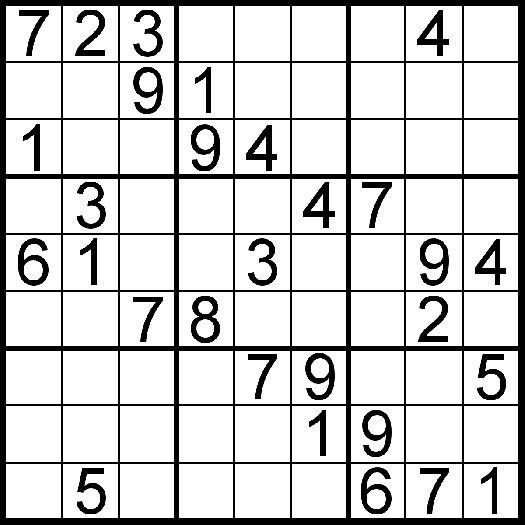

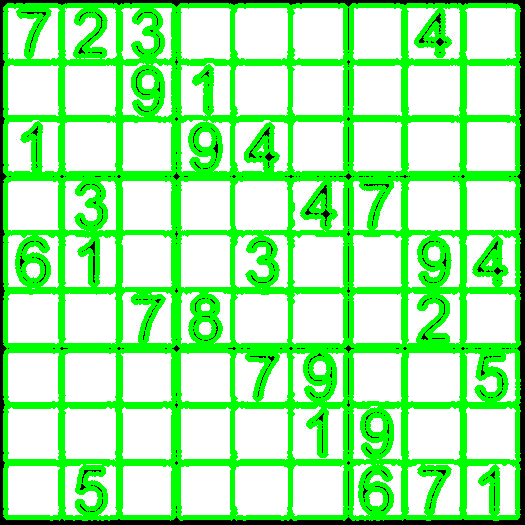

(900, 900)
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
[[9.99999940e-01 4.44623722e-14 1.53579680e-17 7.13329624e-18
  7.84009604e-20 4.68883426e-17 4.81163121e-17 1.01295823e-14
  5.02579803e-18 4.04476189e-15]
 [9.99999940e-01 8.88723485e-15 1.42720637e-18 7.35451163e-18
  3.21702738e-21 2.82767358e-17 9.51330662e-18 2.09010131e-16
  1.79329593e-18 1.03134583e-15]
 [9.99999940e-01 1.99813611e-15 1.09475247e-19 1.15969099e-18
  2.00388467e-22 3.88213977e-18 1.16717366e-18 2.58627101e-17
  1.39991595e-19 1.34626755e-16]
 [9.99999940e-01 9.61004724e-16 2.01914109e-20 9.41768909e-19
  3.04632838e-23 1.72001000e-18 2.55286316e-19 1.49576785e-18
  9.16963766e-20 7.38163869e-17]
 [9.99999940e-01 9.36907802e-16 1.94591186e-20 9.18136772e-19
  2.91796998e-23 1.67659977e-18 2.48004645e-19 1.43480505e-18
  8.90455341e-20 7.17932619e-17]
 [9.99999940e-01 9.21988375e-16 1.91201264e-20 9.01189393e-19
  2.85480431e-23 1.65169615e-18 2.44420627e-19 1.40870750e-18
  8.74892843e-20 7.05592540e-17]
 [9.9999

In [22]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import imutils
from google.colab.patches import cv2_imshow
#from solver import *

classes = np.arange(0, 10)

model = load_model('/content/model-OCR.h5')
# print(model.summary())
input_size = 48


def get_perspective(img, location, height = 900, width = 900):
    """Takes an image and location os interested region.
        And return the only the selected region with a perspective transformation"""
    pts1 = np.float32([location[0], location[3], location[1], location[2]])
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img, matrix, (width, height))
    return result

def get_InvPerspective(img, masked_num, location, height = 900, width = 900):
    """Takes original image as input"""
    pts1 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    pts2 = np.float32([location[0], location[3], location[1], location[2]])

    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(masked_num, matrix, (img.shape[1], img.shape[0]))
    return result

def find_empty(board):
    """checkes where is an empty or unsolved block"""
    for i in range(len(board)):
        for j in range(len(board[0])):
            if board[i][j] == 0:
                return (i, j)  # row, col

    return None

def valid(board, num, pos):
    # Check row
    for i in range(len(board[0])):
        if board[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(board)):
        if board[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if board[i][j] == num and (i,j) != pos:
                return False

    return True


def solve(board):
    find = find_empty(board)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(board, i, (row, col)):
            board[row][col] = i

            if solve(board):
                return True
            board[row][col] = 0
    return False


def get_board(bo):
    """Takes a 9x9 matrix unsolved sudoku board and returns a fully solved board."""
    if solve(bo):
        return bo
    else:
        raise ValueError






def find_board(img):
    """Takes an image as input and finds a sudoku board inside of the image"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray, 13, 20, 20)
    edged = cv2.Canny(bfilter, 30, 180)
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours  = imutils.grab_contours(keypoints)

    newimg = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3)
    cv2_imshow(newimg)


    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
    location = None

    # Finds rectangular contour
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 15, True)
        if len(approx) == 4:
            location = approx
            break
    result = get_perspective(img, location)
    return result, location


# split the board into 81 individual images
def split_boxes(board):
    """Takes a sudoku board and split it into 81 cells.
        each cell contains an element of that board either given or an empty cell."""
    rows = np.vsplit(board,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            box = cv2.resize(box, (input_size, input_size))/255.0
            # cv2.imshow("Splitted block", box)
            # cv2.waitKey(50)
            boxes.append(box)
    cv2.destroyAllWindows()
    return boxes

def displayNumbers(img, numbers, color=(0, 255, 0)):
    """Displays 81 numbers in an image or mask at the same position of each cell of the board"""
    W = int(img.shape[1]/9)
    H = int(img.shape[0]/9)
    for i in range (9):
        for j in range (9):
            if numbers[(j*9)+i] !=0:
                cv2.putText(img, str(numbers[(j*9)+i]), (i*W+int(W/2)-int((W/4)), int((j+0.7)*H)), cv2.FONT_HERSHEY_COMPLEX, 2, color, 2, cv2.LINE_AA)
    return img

# Read image
img = cv2.imread('/content/sudoku.jpg')
cv2_imshow(img)

# extract board from input image
board, location = find_board(img)


gray = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)
print(gray.shape)
rois = split_boxes(gray)
rois = np.array(rois).reshape(-1, input_size, input_size, 1)

# get prediction
prediction = model.predict(rois)
print(prediction)

predicted_numbers = []
# get classes from prediction
for i in prediction:
    index = (np.argmax(i)) # returns the index of the maximum number of the array
    predicted_number = classes[index]
    predicted_numbers.append(predicted_number)

print(predicted_numbers)

# reshape the list
board_num = np.array(predicted_numbers).astype('uint8').reshape(9, 9)
print(board_num)
# solve the board
try:
    #print(get_board(board_num))
    solved_board_nums = get_board(board_num)
    print(solved_board_nums)
    # create a binary array of the predicted numbers. 0 means unsolved numbers of sudoku and 1 means given number.
    binArr = np.where(np.array(predicted_numbers)>0, 0, 1)
    # print(binArr)
    # get only solved numbers for the solved board
    flat_solved_board_nums = solved_board_nums.flatten()*binArr
    # create a mask
    mask = np.zeros_like(board)
    # displays solved numbers in the mask in the same position where board numbers are empty
    solved_board_mask = displayNumbers(mask, flat_solved_board_nums)
    # cv2.imshow("Solved Mask", solved_board_mask)
    inv = get_InvPerspective(img, solved_board_mask, location)
    # cv2.imshow("Inverse Perspective", inv)
    combined = cv2.addWeighted(img, 0.7, inv, 1, 0)
    cv2_imshow("Final result", combined)
    # cv2.waitKey(0)


except:
    print("Solution doesn't exist. Model misread digits.")

#cv2_imshow(img)
# cv2.imshow("Board", board)
cv2.waitKey(0)
cv2.destroyAllWindows()

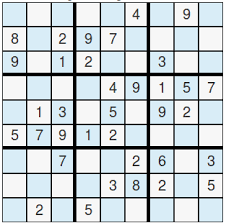

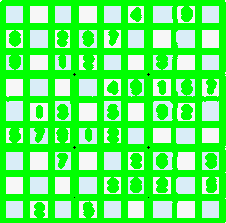

(900, 900)
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
[[9.99999940e-01 3.44648262e-15 6.45898760e-19 6.64571793e-18
  6.31829117e-22 1.69113668e-17 3.84155374e-18 8.69119464e-17
  6.07826738e-19 4.38493816e-16]
 [9.99999940e-01 3.77544311e-15 8.25134478e-19 7.28112251e-18
  8.01086962e-22 1.93125034e-17 4.65713728e-18 1.23424096e-16
  6.72258990e-19 4.94862112e-16]
 [9.99999940e-01 3.77544311e-15 8.25134478e-19 7.28112251e-18
  8.01086962e-22 1.93125034e-17 4.65713728e-18 1.23424096e-16
  6.72258990e-19 4.94862112e-16]
 [9.99999940e-01 3.77544311e-15 8.25134478e-19 7.28112251e-18
  8.01086962e-22 1.93125034e-17 4.65713728e-18 1.23424096e-16
  6.72258990e-19 4.94862112e-16]
 [9.99999940e-01 3.77544311e-15 8.25134478e-19 7.28112251e-18
  8.01086962e-22 1.93125034e-17 4.65713728e-18 1.23424096e-16
  6.72258990e-19 4.94862112e-16]
 [9.99999940e-01 3.77544311e-15 8.25134478e-19 7.28112251e-18
  8.01086962e-22 1.93125034e-17 4.65713728e-18 1.23424096e-16
  6.72258990e-19 4.94862112e-16]
 [9.9999

In [14]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import imutils
from google.colab.patches import cv2_imshow
#from solver import *

classes = np.arange(0, 10)

model = load_model('/content/model-OCR.h5')
# print(model.summary())
input_size = 48


def get_perspective(img, location, height = 900, width = 900):
    """Takes an image and location os interested region.
        And return the only the selected region with a perspective transformation"""
    pts1 = np.float32([location[0], location[3], location[1], location[2]])
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img, matrix, (width, height))
    return result

def get_InvPerspective(img, masked_num, location, height = 900, width = 900):
    """Takes original image as input"""
    pts1 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    pts2 = np.float32([location[0], location[3], location[1], location[2]])

    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(masked_num, matrix, (img.shape[1], img.shape[0]))
    return result

def find_empty(board):
    """checkes where is an empty or unsolved block"""
    for i in range(len(board)):
        for j in range(len(board[0])):
            if board[i][j] == 0:
                return (i, j)  # row, col

    return None

def valid(board, num, pos):
    # Check row
    for i in range(len(board[0])):
        if board[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(board)):
        if board[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if board[i][j] == num and (i,j) != pos:
                return False

    return True


def solve(board):
    find = find_empty(board)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(board, i, (row, col)):
            board[row][col] = i

            if solve(board):
                return True
            board[row][col] = 0
    return False


def get_board(bo):
    """Takes a 9x9 matrix unsolved sudoku board and returns a fully solved board."""
    if solve(bo):
        return bo
    else:
        raise ValueError






def find_board(img):
    """Takes an image as input and finds a sudoku board inside of the image"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray, 13, 20, 20)
    edged = cv2.Canny(bfilter, 30, 180)
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours  = imutils.grab_contours(keypoints)

    newimg = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3)
    cv2_imshow(newimg)


    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
    location = None

    # Finds rectangular contour
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 15, True)
        if len(approx) == 4:
            location = approx
            break
    result = get_perspective(img, location)
    return result, location


# split the board into 81 individual images
def split_boxes(board):
    """Takes a sudoku board and split it into 81 cells.
        each cell contains an element of that board either given or an empty cell."""
    rows = np.vsplit(board,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            box = cv2.resize(box, (input_size, input_size))/255.0
            # cv2.imshow("Splitted block", box)
            # cv2.waitKey(50)
            boxes.append(box)
    cv2.destroyAllWindows()
    return boxes

def displayNumbers(img, numbers, color=(0, 255, 0)):
    """Displays 81 numbers in an image or mask at the same position of each cell of the board"""
    W = int(img.shape[1]/9)
    H = int(img.shape[0]/9)
    for i in range (9):
        for j in range (9):
            if numbers[(j*9)+i] !=0:
                cv2.putText(img, str(numbers[(j*9)+i]), (i*W+int(W/2)-int((W/4)), int((j+0.7)*H)), cv2.FONT_HERSHEY_COMPLEX, 2, color, 2, cv2.LINE_AA)
    return img

# Read image
img = cv2.imread('/content/sudoku5.png')
cv2_imshow(img)

# extract board from input image
board, location = find_board(img)


gray = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)
print(gray.shape)
rois = split_boxes(gray)
rois = np.array(rois).reshape(-1, input_size, input_size, 1)

# get prediction
prediction = model.predict(rois)
print(prediction)

predicted_numbers = []
# get classes from prediction
for i in prediction:
    index = (np.argmax(i)) # returns the index of the maximum number of the array
    predicted_number = classes[index]
    predicted_numbers.append(predicted_number)

print(predicted_numbers)

# reshape the list
board_num = np.array(predicted_numbers).astype('uint8').reshape(9, 9)
print(board_num)
# solve the board
try:
    #print(get_board(board_num))
    solved_board_nums = get_board(board_num)
    print(solved_board_nums)
    # create a binary array of the predicted numbers. 0 means unsolved numbers of sudoku and 1 means given number.
    binArr = np.where(np.array(predicted_numbers)>0, 0, 1)
    # print(binArr)
    # get only solved numbers for the solved board
    flat_solved_board_nums = solved_board_nums.flatten()*binArr
    # create a mask
    mask = np.zeros_like(board)
    # displays solved numbers in the mask in the same position where board numbers are empty
    solved_board_mask = displayNumbers(mask, flat_solved_board_nums)
    # cv2.imshow("Solved Mask", solved_board_mask)
    inv = get_InvPerspective(img, solved_board_mask, location)
    # cv2.imshow("Inverse Perspective", inv)
    combined = cv2.addWeighted(img, 0.7, inv, 1, 0)
    cv2_imshow("Final result", combined)
    # cv2.waitKey(0)


except:
    print("Solution doesn't exist. Model misread digits.")

#cv2_imshow(img)
# cv2.imshow("Board", board)
cv2.waitKey(0)
cv2.destroyAllWindows()

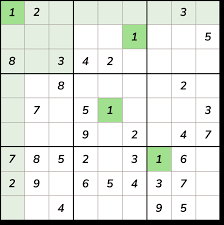

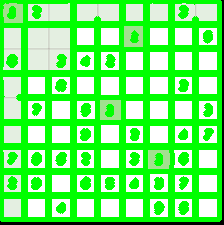

(900, 900)
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
[[3.66723543e-05 9.95545983e-01 5.13790255e-05 1.75709210e-05
  2.53108010e-04 1.62711167e-05 5.58889360e-06 3.95131670e-03
  5.99382383e-06 1.16086587e-04]
 [7.94832374e-07 1.01187334e-06 6.04423555e-03 9.91939723e-01
  1.32188998e-05 1.33775279e-03 1.46672585e-06 1.70041058e-05
  6.01731066e-04 4.30009277e-05]
 [9.99999940e-01 1.62245197e-14 2.24990624e-18 1.12110449e-16
  2.76726953e-21 9.30535176e-17 1.30094996e-17 4.26926476e-17
  9.52460011e-18 2.22398580e-15]
 [9.99999940e-01 1.18109198e-14 5.65190385e-19 2.11677967e-17
  1.34811426e-21 3.79323919e-17 5.84967612e-18 3.09219833e-17
  2.57394722e-18 1.39020130e-15]
 [9.99999940e-01 4.00426271e-15 1.34693322e-19 5.20747584e-18
  2.60557450e-22 9.23966204e-18 1.48513579e-18 8.43890736e-18
  5.58850873e-19 3.42330166e-16]
 [9.99999940e-01 1.03387529e-14 6.00332999e-19 2.13099047e-17
  1.21601629e-21 3.56152936e-17 5.64613179e-18 2.86981512e-17
  2.48569263e-18 1.17410159e-15]
 [9.9999

In [15]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import imutils
from google.colab.patches import cv2_imshow
#from solver import *

classes = np.arange(0, 10)

model = load_model('/content/model-OCR.h5')
# print(model.summary())
input_size = 48


def get_perspective(img, location, height = 900, width = 900):
    """Takes an image and location os interested region.
        And return the only the selected region with a perspective transformation"""
    pts1 = np.float32([location[0], location[3], location[1], location[2]])
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img, matrix, (width, height))
    return result

def get_InvPerspective(img, masked_num, location, height = 900, width = 900):
    """Takes original image as input"""
    pts1 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    pts2 = np.float32([location[0], location[3], location[1], location[2]])

    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(masked_num, matrix, (img.shape[1], img.shape[0]))
    return result

def find_empty(board):
    """checkes where is an empty or unsolved block"""
    for i in range(len(board)):
        for j in range(len(board[0])):
            if board[i][j] == 0:
                return (i, j)  # row, col

    return None

def valid(board, num, pos):
    # Check row
    for i in range(len(board[0])):
        if board[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(board)):
        if board[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if board[i][j] == num and (i,j) != pos:
                return False

    return True


def solve(board):
    find = find_empty(board)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(board, i, (row, col)):
            board[row][col] = i

            if solve(board):
                return True
            board[row][col] = 0
    return False


def get_board(bo):
    """Takes a 9x9 matrix unsolved sudoku board and returns a fully solved board."""
    if solve(bo):
        return bo
    else:
        raise ValueError






def find_board(img):
    """Takes an image as input and finds a sudoku board inside of the image"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray, 13, 20, 20)
    edged = cv2.Canny(bfilter, 30, 180)
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours  = imutils.grab_contours(keypoints)

    newimg = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3)
    cv2_imshow(newimg)


    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
    location = None

    # Finds rectangular contour
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 15, True)
        if len(approx) == 4:
            location = approx
            break
    result = get_perspective(img, location)
    return result, location


# split the board into 81 individual images
def split_boxes(board):
    """Takes a sudoku board and split it into 81 cells.
        each cell contains an element of that board either given or an empty cell."""
    rows = np.vsplit(board,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            box = cv2.resize(box, (input_size, input_size))/255.0
            # cv2.imshow("Splitted block", box)
            # cv2.waitKey(50)
            boxes.append(box)
    cv2.destroyAllWindows()
    return boxes

def displayNumbers(img, numbers, color=(0, 255, 0)):
    """Displays 81 numbers in an image or mask at the same position of each cell of the board"""
    W = int(img.shape[1]/9)
    H = int(img.shape[0]/9)
    for i in range (9):
        for j in range (9):
            if numbers[(j*9)+i] !=0:
                cv2.putText(img, str(numbers[(j*9)+i]), (i*W+int(W/2)-int((W/4)), int((j+0.7)*H)), cv2.FONT_HERSHEY_COMPLEX, 2, color, 2, cv2.LINE_AA)
    return img

# Read image
img = cv2.imread('/content/sudoku6.png')
cv2_imshow(img)

# extract board from input image
board, location = find_board(img)


gray = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)
print(gray.shape)
rois = split_boxes(gray)
rois = np.array(rois).reshape(-1, input_size, input_size, 1)

# get prediction
prediction = model.predict(rois)
print(prediction)

predicted_numbers = []
# get classes from prediction
for i in prediction:
    index = (np.argmax(i)) # returns the index of the maximum number of the array
    predicted_number = classes[index]
    predicted_numbers.append(predicted_number)

print(predicted_numbers)

# reshape the list
board_num = np.array(predicted_numbers).astype('uint8').reshape(9, 9)
print(board_num)
# solve the board
try:
    #print(get_board(board_num))
    solved_board_nums = get_board(board_num)
    print(solved_board_nums)
    # create a binary array of the predicted numbers. 0 means unsolved numbers of sudoku and 1 means given number.
    binArr = np.where(np.array(predicted_numbers)>0, 0, 1)
    # print(binArr)
    # get only solved numbers for the solved board
    flat_solved_board_nums = solved_board_nums.flatten()*binArr
    # create a mask
    mask = np.zeros_like(board)
    # displays solved numbers in the mask in the same position where board numbers are empty
    solved_board_mask = displayNumbers(mask, flat_solved_board_nums)
    # cv2.imshow("Solved Mask", solved_board_mask)
    inv = get_InvPerspective(img, solved_board_mask, location)
    # cv2.imshow("Inverse Perspective", inv)
    combined = cv2.addWeighted(img, 0.7, inv, 1, 0)
    cv2_imshow("Final result", combined)
    # cv2.waitKey(0)


except:
    print("Solution doesn't exist. Model misread digits.")

#cv2_imshow(img)
# cv2.imshow("Board", board)
cv2.waitKey(0)
cv2.destroyAllWindows()

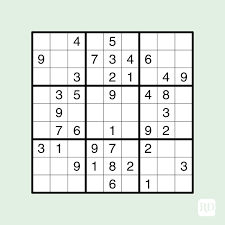

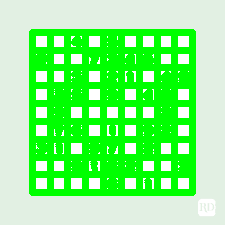

(900, 900)
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
[[9.99999940e-01 4.17395849e-12 3.75726832e-15 2.09982813e-15
  4.35439852e-17 8.88096512e-15 8.65854189e-15 1.09127887e-12
  1.76627079e-15 7.07650681e-13]
 [9.99999940e-01 2.86672460e-13 1.84476828e-16 7.86713084e-17
  1.08627085e-18 3.85321111e-16 3.93115799e-16 6.40513440e-14
  6.21691081e-17 3.06048826e-14]
 [4.39254590e-13 3.79245879e-09 2.98541990e-11 1.58297973e-14
  9.99999940e-01 8.17229193e-16 1.13030189e-10 3.90223513e-11
  1.82478355e-11 9.17265819e-10]
 [9.99999940e-01 1.97561737e-12 1.23326271e-15 5.51656518e-16
  1.56125014e-17 2.72036659e-15 3.25006987e-15 5.69213350e-13
  4.81168871e-16 2.67332001e-13]
 [3.13118497e-21 6.00064201e-22 3.52680142e-11 1.51983664e-13
  2.57970620e-19 9.99999940e-01 1.10186621e-12 2.89364931e-16
  1.75704805e-18 6.12344602e-17]
 [9.99999940e-01 1.54889166e-12 1.24477167e-15 3.34899225e-16
  1.31055841e-17 1.85209535e-15 2.48185905e-15 4.67717824e-13
  3.68164406e-16 1.42755287e-13]
 [9.9999

In [16]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import imutils
from google.colab.patches import cv2_imshow
#from solver import *

classes = np.arange(0, 10)

model = load_model('/content/model-OCR.h5')
# print(model.summary())
input_size = 48


def get_perspective(img, location, height = 900, width = 900):
    """Takes an image and location os interested region.
        And return the only the selected region with a perspective transformation"""
    pts1 = np.float32([location[0], location[3], location[1], location[2]])
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img, matrix, (width, height))
    return result

def get_InvPerspective(img, masked_num, location, height = 900, width = 900):
    """Takes original image as input"""
    pts1 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    pts2 = np.float32([location[0], location[3], location[1], location[2]])

    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(masked_num, matrix, (img.shape[1], img.shape[0]))
    return result

def find_empty(board):
    """checkes where is an empty or unsolved block"""
    for i in range(len(board)):
        for j in range(len(board[0])):
            if board[i][j] == 0:
                return (i, j)  # row, col

    return None

def valid(board, num, pos):
    # Check row
    for i in range(len(board[0])):
        if board[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(board)):
        if board[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if board[i][j] == num and (i,j) != pos:
                return False

    return True


def solve(board):
    find = find_empty(board)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(board, i, (row, col)):
            board[row][col] = i

            if solve(board):
                return True
            board[row][col] = 0
    return False


def get_board(bo):
    """Takes a 9x9 matrix unsolved sudoku board and returns a fully solved board."""
    if solve(bo):
        return bo
    else:
        raise ValueError






def find_board(img):
    """Takes an image as input and finds a sudoku board inside of the image"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray, 13, 20, 20)
    edged = cv2.Canny(bfilter, 30, 180)
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours  = imutils.grab_contours(keypoints)

    newimg = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3)
    cv2_imshow(newimg)


    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
    location = None

    # Finds rectangular contour
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 15, True)
        if len(approx) == 4:
            location = approx
            break
    result = get_perspective(img, location)
    return result, location


# split the board into 81 individual images
def split_boxes(board):
    """Takes a sudoku board and split it into 81 cells.
        each cell contains an element of that board either given or an empty cell."""
    rows = np.vsplit(board,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            box = cv2.resize(box, (input_size, input_size))/255.0
            # cv2.imshow("Splitted block", box)
            # cv2.waitKey(50)
            boxes.append(box)
    cv2.destroyAllWindows()
    return boxes

def displayNumbers(img, numbers, color=(0, 255, 0)):
    """Displays 81 numbers in an image or mask at the same position of each cell of the board"""
    W = int(img.shape[1]/9)
    H = int(img.shape[0]/9)
    for i in range (9):
        for j in range (9):
            if numbers[(j*9)+i] !=0:
                cv2.putText(img, str(numbers[(j*9)+i]), (i*W+int(W/2)-int((W/4)), int((j+0.7)*H)), cv2.FONT_HERSHEY_COMPLEX, 2, color, 2, cv2.LINE_AA)
    return img

# Read image
img = cv2.imread('/content/sudoku7.png')
cv2_imshow(img)

# extract board from input image
board, location = find_board(img)


gray = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)
print(gray.shape)
rois = split_boxes(gray)
rois = np.array(rois).reshape(-1, input_size, input_size, 1)

# get prediction
prediction = model.predict(rois)
print(prediction)

predicted_numbers = []
# get classes from prediction
for i in prediction:
    index = (np.argmax(i)) # returns the index of the maximum number of the array
    predicted_number = classes[index]
    predicted_numbers.append(predicted_number)

print(predicted_numbers)

# reshape the list
board_num = np.array(predicted_numbers).astype('uint8').reshape(9, 9)
print(board_num)
# solve the board
try:
    #print(get_board(board_num))
    solved_board_nums = get_board(board_num)
    print(solved_board_nums)
    # create a binary array of the predicted numbers. 0 means unsolved numbers of sudoku and 1 means given number.
    binArr = np.where(np.array(predicted_numbers)>0, 0, 1)
    # print(binArr)
    # get only solved numbers for the solved board
    flat_solved_board_nums = solved_board_nums.flatten()*binArr
    # create a mask
    mask = np.zeros_like(board)
    # displays solved numbers in the mask in the same position where board numbers are empty
    solved_board_mask = displayNumbers(mask, flat_solved_board_nums)
    # cv2.imshow("Solved Mask", solved_board_mask)
    inv = get_InvPerspective(img, solved_board_mask, location)
    # cv2.imshow("Inverse Perspective", inv)
    combined = cv2.addWeighted(img, 0.7, inv, 1, 0)
    cv2_imshow("Final result", combined)
    # cv2.waitKey(0)


except:
    print("Solution doesn't exist. Model misread digits.")

#cv2_imshow(img)
# cv2.imshow("Board", board)
cv2.waitKey(0)
cv2.destroyAllWindows()